<a href="https://colab.research.google.com/github/axk817/RIT_IMGS789/blob/main/DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import layers, optimizers
import matplotlib.pyplot as plt
import numpy as np

# Load CIFAR-10 dataset
(train_images, train_labels), (_, _) = tf.keras.datasets.cifar10.load_data()

# Preprocess images
train_images = train_images.astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize to [-1, 1]

# Define the generator model
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    model.add(layers.Reshape((8, 8, 256)))
    assert model.output_shape == (None, 8, 8, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 16, 16, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 32, 32, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(1, 1), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 32, 32, 3)

    return model

# Define the discriminator model
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

# Define the loss functions and optimizers
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

# Define the training loop
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16
BATCH_SIZE = 256
BUFFER_SIZE = 60000

# Reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
# Define the training loop with separate optimization and TTUR
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output  = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))


    if tf.math.mod(discriminator_optimizer.iterations, 5) == 0:  # Update generator every 5 discriminator steps
        gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
        generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))

    return gen_loss, disc_loss
# Lists to store generator and discriminator losses
gen_losses = []
disc_losses = []
def train(dataset, epochs):
  for epoch in range(epochs):
    for image_batch in dataset:
      gen_loss, disc_loss = train_step(image_batch)
      gen_losses.append(gen_loss)  # Append generator loss
      disc_losses.append(disc_loss)  # Append discriminator loss

    # Produce images for the GIF as you go
    #display.clear_output(wait=True)
    generate_and_save_images(generator, epoch + 1, seed)

    print ('Epoch {}: Generator loss: {}, Discriminator loss: {}'.format(epoch +1, gen_loss, disc_loss))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow((predictions[i, :, :, :] + 1) / 2)
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [ ]:
# Create and train the models
generator = make_generator_model()
discriminator = make_discriminator_model()

generator.summary()
discriminator.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 16384)             1638400   
                                                                 
 batch_normalization_9 (Batc  (None, 16384)            65536     
 hNormalization)                                                 
                                                                 
 re_lu_9 (ReLU)              (None, 16384)             0         
                                                                 
 reshape_3 (Reshape)         (None, 8, 8, 256)         0         
                                                                 
 conv2d_transpose_9 (Conv2DT  (None, 16, 16, 128)      819200    
 ranspose)                                                       
                                                                 
 batch_normalization_10 (Bat  (None, 16, 16, 128)     

In [ ]:
EPOCHS = 5  # Increase the number of epochs
generator_optimizer = optimizers.RMSprop(learning_rate=2e-4)  # Adjust learning rate and beta_1
discriminator_optimizer = optimizers.RMSprop(learning_rate=2e-4)

# Add data augmentation
def augment_image(image):
  image = tf.image.random_flip_left_right(image)
  image = tf.image.random_brightness(image, max_delta=0.2)
  # Add more augmentation techniques as needed
  return image

2024-11-15 20:38:17.593828: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [50000,32,32,3]
	 [[{{node Placeholder/_0}}]]
2024-11-15 20:38:17.594025: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [50000,32,32,3]
	 [[{{node Placeholder/_0}}]]


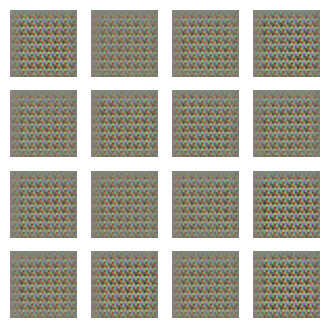

Epoch 1: Generator loss: 1.0160367488861084, Discriminator loss: 0.5885984301567078


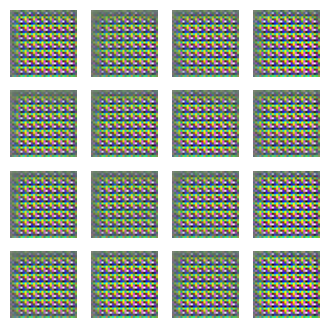

Epoch 2: Generator loss: 3.887939929962158, Discriminator loss: 0.10662541538476944


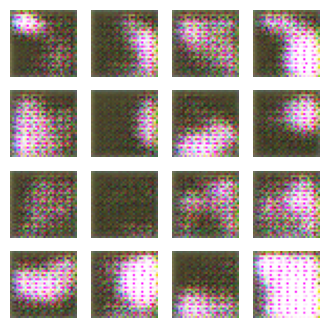

Epoch 3: Generator loss: 1.881278157234192, Discriminator loss: 0.7485866546630859


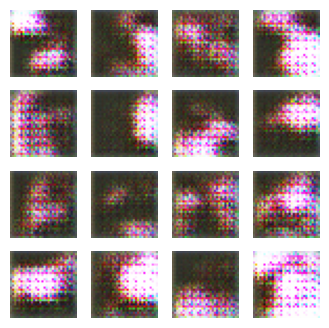

Epoch 4: Generator loss: 2.1784720420837402, Discriminator loss: 0.6198379993438721


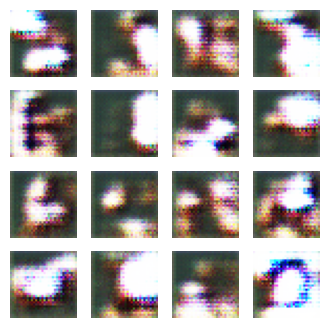

Epoch 5: Generator loss: 2.187683582305908, Discriminator loss: 0.4446758031845093


AttributeError: 'function' object has no attribute 'clear_output'

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images)
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
train(train_dataset, EPOCHS)

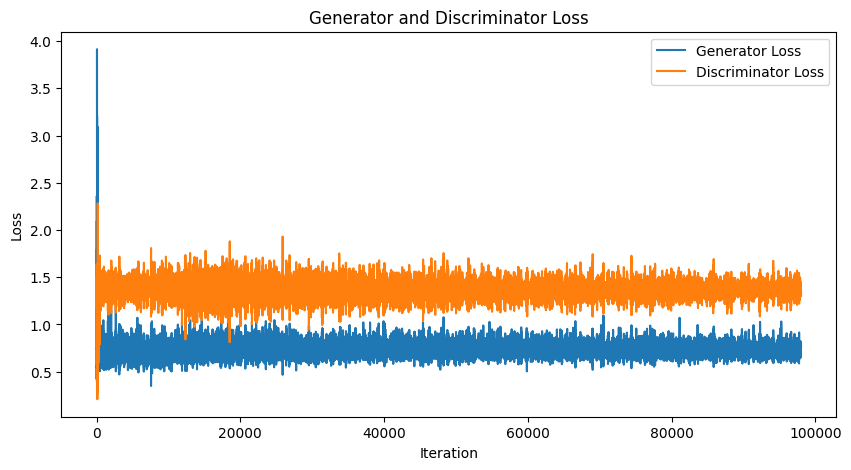

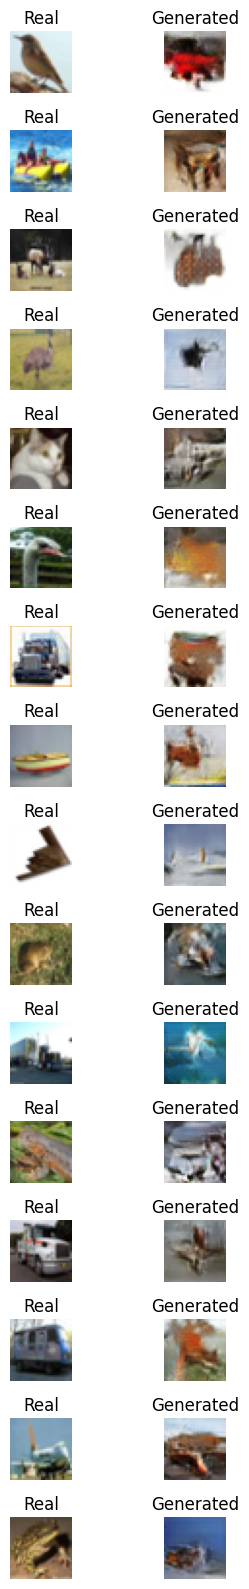

In [ ]:
# After training, plot the losses
plt.figure(figsize=(10, 5))
plt.plot(gen_losses, label="Generator Loss")
plt.plot(disc_losses, label="Discriminator Loss")
plt.xlabel("Iteration")

plt.ylabel("Loss")
plt.legend()
plt.title("Generator and Discriminator Loss")
plt.show()

# Function to display real and generated images side-by-side
def compare_images(model, test_input, train_images):
  # Generate images from the model
  predictions = model(test_input, training=False)

  # Select a random sample of real images
  rand_indices = np.random.randint(0, train_images.shape[0], size=num_examples_to_generate)
  real_images = train_images[rand_indices]

  # Create a figure to display the images
  fig, axes = plt.subplots(nrows=num_examples_to_generate, ncols=2, figsize=(4, 16))

  for i in range(num_examples_to_generate):
      # Display real image
      axes[i, 0].imshow((real_images[i] + 1) / 2)
      axes[i, 0].axis('off')
      axes[i, 0].set_title('Real')

      # Display generated image
      axes[i, 1].imshow((predictions[i] + 1) / 2)
      axes[i, 1].axis('off')
      axes[i, 1].set_title('Generated')

  plt.tight_layout()
  plt.show()

# ... (after training the model)

# Compare generated images with real images
compare_images(generator, seed, train_images)

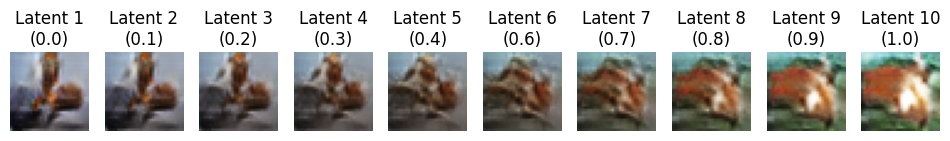

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
from IPython import display

# Function for latent space interpolation
def interpolate_latent_space(model, latent_dim, num_interpolations=10):
  # Generate two distinct latent vectors
  latent_vector_1 = tf.random.normal([1, latent_dim])
  latent_vector_2 = tf.random.normal([1, latent_dim])

  # Interpolate between the latent vectors
  interpolated_vectors = []
  for i in range(num_interpolations):
      alpha = i / (num_interpolations - 1)
      interpolated_vector = latent_vector_1 * (1 - alpha) + latent_vector_2 * alpha
      interpolated_vectors.append(interpolated_vector)

  # Generate images from the interpolated latent vectors
  interpolated_images = []
  for vector in interpolated_vectors:
      img = model(vector, training=False)
      interpolated_images.append(img)

  # Display the interpolated images with labels
  fig = plt.figure(figsize=(12, 4))
  for i, img in enumerate(interpolated_images):
      plt.subplot(1, num_interpolations, i+1)
      plt.imshow((img[0, :, :, :] + 1) / 2)
      plt.axis('off')
      # Add labels for latent space # and transition
      alpha = i / (num_interpolations - 1)
      plt.title(f"Latent {i+1}\n({alpha:.1f})")


  plt.show()


# Perform latent space interpolation
interpolate_latent_space(generator, noise_dim)